## Data Wrangling
### Contents
#### <a href="#Import"> Import </a>
#### <a href="#Discovery"> Initial Discovery </a> 
#### <a href="#Duplicates"> Check for Duplicates </a>
#### <a href="#VIN"> Fill Empty 'Year' Values by VIN Number </a>
#### <a href="#Drop"> Drop Special Conditions </a>
#### <a href="#KNN"> KNN Impute Missing Values </a>
#### <a href="#Fillna"> Custom Fill Missing Values </a>
#### <a href="#Simple"> Simple Imputer </a>
#### <a href="#Conclusion"> Data Wrangling Conclusion </a>

### <span id="Import"> Import </span>

In [1]:
#import the appropriate dependencies
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

In [2]:
#import the data into a dataframe: df
# download the data from 'https://www.kaggle.com/austinreese/craigslist-carstrucks-data?select=vehicles.csv'

csv_file = './data/vehicles.csv'

df = pd.read_csv(csv_file)

### <span id="Discovery"> Initial Discovery </span>

In [78]:
df.shape

(423857, 26)

In [3]:
#check what the data head looks like
df.head(3)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7184791621,https://duluth.craigslist.org/ctd/d/duluth-200...,duluth / superior,https://duluth.craigslist.org,6995,2000.0,gmc,new sierra 1500,excellent,8 cylinders,...,4wd,NaN,NaN,red,https://images.craigslist.org/00n0n_f06ykBMcdh...,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,NaN,mn,46.8433,-92.2550
1,7184773187,https://duluth.craigslist.org/cto/d/saginaw-20...,duluth / superior,https://duluth.craigslist.org,8750,2013.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,NaN,grey,https://images.craigslist.org/00d0d_kgZ6xoeRw2...,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,NaN,mn,46.9074,-92.4638
2,7193375964,https://newhaven.craigslist.org/cto/d/stratfor...,new haven,https://newhaven.craigslist.org,10900,2013.0,toyota,prius,good,4 cylinders,...,fwd,NaN,NaN,blue,https://images.craigslist.org/00d0d_3sHGxPbY2O...,2013 Prius V Model Two. One owner—must sell my...,NaN,ct,41.1770,-73.1336


In [4]:
#view descriptive statistics from numerical columns
df.describe()

,id,price,year,odometer,county,lat,long
count,4.238570e+05,4.238570e+05,328743.000000,2.705850e+05,0.0,324404.000000,324404.000000
mean,7.190602e+09,5.779437e+04,2009.827358,9.942578e+04,NaN,38.731429,-93.949367
std,5.159269e+06,1.002581e+07,10.135809,1.204833e+05,NaN,5.902977,17.930566
min,7.178302e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-80.386400,-161.394000
25%,7.186688e+09,4.499000e+03,2007.000000,4.432400e+04,NaN,35.054500,-106.678000
50%,7.192068e+09,9.995000e+03,2012.000000,9.174900e+04,NaN,39.366900,-88.009900
75%,7.194909e+09,1.899500e+04,2016.000000,1.372370e+05,NaN,42.517075,-80.832500
max,7.197006e+09,3.808256e+09,2021.000000,1.000000e+07,NaN,80.383400,115.524000


Not all the data will be relevant to the current business model. Taking a look at the minimum odometer reading tells us that there is at least one new car in the data, which might affect our model for used car prices. **So, consider dropping the rows with 0 miles in 'odometer'** 

The min and max values in 'price' are 0 and 3808256046 respectively. Such a high price makes me think this is a typo. We can either try to find the data manually from its source to check or **drop anything over 500,000 dollars completely**. Similarly, **we will drop any vehicles that have a price under 100 dollars for consistency.**

The 'year' column has a max value of 2021, which tells us that it is a new car because it is next year's date. To correct for this new car, we will **drop the rows with a year of 2021.** Similarly, the scope of this project only involves vehicles 30 years old or younger. Consequently, we will drop any irrelevant data by **dropping all rows that have a year less than 1990.**

In [5]:
#view a list of the column names
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [6]:
#check the types of data for each column
df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
vin              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
dtype: object

Looking at the types of data per column gives insight to how we will manipulate the data. Also, we can anticipate needing dummy variables in our preprocessing phase later. 

Cylinders is currently an object (string), but it may be more sensible to convert this to an int64.

In [7]:
#check for empty values
df.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year             95114
manufacturer    110615
model            98473
condition       247138
cylinders       226178
fuel             96643
odometer        153272
title_status     96098
transmission     95792
vin             239437
drive           192738
size            321230
type            182700
paint_color     201654
image_url        94196
description      94203
county          423857
state                0
lat              99453
long             99453
dtype: int64

<AxesSubplot:>

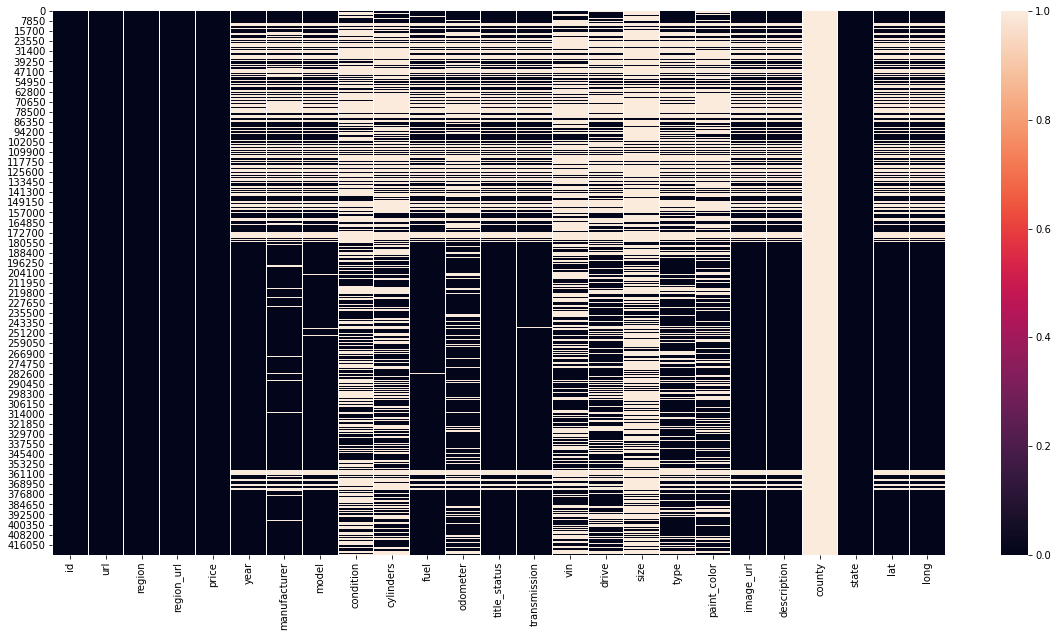

In [8]:
#set the size of the plot to make it easier to view
plt.figure(figsize=(20,10))

#use seaborn's heatmap to visualize where the null values are
sns.heatmap(df.isnull())

**There is a lot of missing data in this dataset.** Once we explore the data and understand more about how the columns correlate, we will be able to make an informed decision on what to do. **Some options include deleting entire rows and imputing with mean or other stats, or using KNN.**  

County does not have any values in it. **Does the county column add any value?** 

**These columns have the most missing values: condition, cylinders, vin, drive, size, type, paint_color, and county.**

### <span id="Duplicates"> Check For Duplicates </span> 

In [9]:
#check for duplicates
if df.duplicated().sum() == 0:
    print('No duplicates!')
else:
    df.duplicated().sum()

No duplicates!


### <span id="VIN"> Fill Empty 'Year' Values by VIN Number </span>

NOTE: The 10th digit in a 17 digit VIN number contains the year. So, we can use the VIN number to impute any missing year values where a VIN number is present.

In [10]:
#string form of years from 1990 to 2019 according to 'https://support.alldata.com/alldata-repair-online-article/vin-to-year-chart#:~:text=The%2010th%20character%20in%20the,built%20in%20or%20after%201981.'
keys = 'LMNPRSTVWXY123456789ABCDEFGHJK'

#use dict comprehension to create dictionary for vin and year
vin_year_dict = {key:1990+i for i,key in enumerate(keys)}

#visualize vin_year_dict
vin_year_dict

{'L': 1990,
 'M': 1991,
 'N': 1992,
 'P': 1993,
 'R': 1994,
 'S': 1995,
 'T': 1996,
 'V': 1997,
 'W': 1998,
 'X': 1999,
 'Y': 2000,
 '1': 2001,
 '2': 2002,
 '3': 2003,
 '4': 2004,
 '5': 2005,
 '6': 2006,
 '7': 2007,
 '8': 2008,
 '9': 2009,
 'A': 2010,
 'B': 2011,
 'C': 2012,
 'D': 2013,
 'E': 2014,
 'F': 2015,
 'G': 2016,
 'H': 2017,
 'J': 2018,
 'K': 2019}

In [11]:
#define function to check if vin number is a string and 17 char in length (validation)
def check_str(value):
    if type(value) == str and len(value) == 17:
        return value[9]
    else:
        return False

In [12]:
#get year from vin and add to vin_year column
df['vin_year'] = [vin_year_dict[v[9]] if (check_str(v) in vin_year_dict.keys()) else np.nan for i,v in enumerate(df['vin']) ]

In [13]:
miss_year = df['year'].isnull()
df.loc[miss_year,['year','vin_year']]

,year,vin_year
2431,NaN,1990.0
4565,NaN,2019.0
4908,NaN,1990.0
4910,NaN,1990.0
5563,NaN,2019.0
...,...,...
417144,NaN,1990.0
417744,NaN,2019.0
418703,NaN,2018.0
421044,NaN,NaN


#### Missing 'year' values BEFORE FillNA

In [14]:
#missing number of years before fillna
df['year'].isnull().sum()

95114

#### FillNA in action

In [15]:
#fill na values in 'year' column with vin_year 'column' as a float to match 'year' column type
df['year'] = df['year'].fillna(df['vin_year'].astype('float64'))

#### Missing 'year' values AFTER FillNA

In [16]:
#missing number of years after fillna -- 914 values filled from the vin!!
df['year'].isnull().sum()

94200

In [17]:
#check if previously nan value (index of 4565) was filled correctly
df['year'][4565]

2019.0

Now we have all the possible year values exractable from other columns.

In [18]:
#check for outliers in year values
df['year'].value_counts().sort_values(ascending=True).head(14)

1911.0    1
1922.0    1
1925.0    1
1912.0    1
1915.0    1
1917.0    1
1913.0    1
1920.0    2
1919.0    3
1901.0    3
1918.0    3
1945.0    4
1944.0    4
1943.0    6
Name: year, dtype: int64

### <span id="Drop"> Drop special conditions </span>

#### Drop the business specific rows

In [19]:
#define the conditions to drop (based on the business model)
zero_odometer = df['odometer']<5000
max_price = df['price']>=500000
min_price = df['price']<=100
future_year = df['year']==2021
min_year = df['year'].astype('float64')<1990

#drop those conditions
dropped_df = df.drop(df.loc[zero_odometer|max_price|min_price|future_year|min_year].index)

dropped_df.describe()

,id,price,year,odometer,county,lat,long,vin_year
count,3.673810e+05,367381.00000,281131.000000,2.358140e+05,0.0,279343.000000,279343.000000,159293.000000
mean,7.190709e+09,15043.18888,2011.074382,1.042051e+05,NaN,38.788533,-93.790007,2012.333794
std,5.157905e+06,13701.66971,5.903410,1.101406e+05,NaN,5.944142,17.833631,5.519919
min,7.178302e+09,101.00000,1990.000000,5.000000e+03,NaN,-80.386400,-161.394000,1990.000000
25%,7.186855e+09,5950.00000,2007.000000,5.048800e+04,NaN,35.083750,-106.522000,2009.000000
50%,7.192309e+09,11495.00000,2012.000000,9.624200e+04,NaN,39.494500,-87.843300,2014.000000
75%,7.195000e+09,19990.00000,2016.000000,1.415875e+05,NaN,42.586550,-80.958900,2017.000000
max,7.197006e+09,479500.00000,2020.000000,1.000000e+07,NaN,80.383400,115.524000,2019.000000


In [20]:
#drop county column as there is not data here
dropped_df.drop(columns=['county'], inplace=True)

In [21]:
#drop the rows missing the manufacturer and model
dropped_df.drop(dropped_df.loc[(dropped_df['manufacturer'].isna())|(dropped_df['model'].isna())].index, inplace=True)

In [22]:
#check if county column dropped
set(dropped_df.columns).symmetric_difference(set(df.columns))

{'county'}

In [23]:
#if count of missing values > 90% of total column then drop the column
total_null = dropped_df.isna().sum()
total = len(dropped_df.index)
percent_null = round((total_null/total)*100, 0)
percent_null.sort_values(ascending=False)

size            69.0
condition       45.0
vin_year        42.0
vin             42.0
cylinders       38.0
paint_color     31.0
drive           28.0
type            26.0
odometer        15.0
long             1.0
fuel             1.0
lat              1.0
region_url       0.0
manufacturer     0.0
region           0.0
price            0.0
url              0.0
year             0.0
title_status     0.0
model            0.0
transmission     0.0
image_url        0.0
description      0.0
state            0.0
id               0.0
dtype: float64

Looks like the highest ratio of missing values is from the size column at 69%. This concludes that we will not be dropping any more columns at this time. The next questions are 
* 1) Are there rows with more than 90% missing values? drop them. 
* 2) What do the missing values really tell us? and 
* 3) What do we do now about those missing values? Impute the mean, for example


In [24]:
# 1) 

#if count of missing values > 90% of total row then drop the row
#can i use map and lambda to make function quicker?
miss_maj_row = [True if row.isnull().sum() > (len(row)*0.9)-4 else False for idx,row in dropped_df.iterrows()]

In [25]:
#check for rows to be dropped
miss_maj_row.count(True)

0

In [26]:
#test = dropped_df.map({np.nan:True,})

#drop rows where missing data is more than 90%
dropped_df.drop(dropped_df.loc[miss_maj_row].index, inplace=True)

<AxesSubplot:>

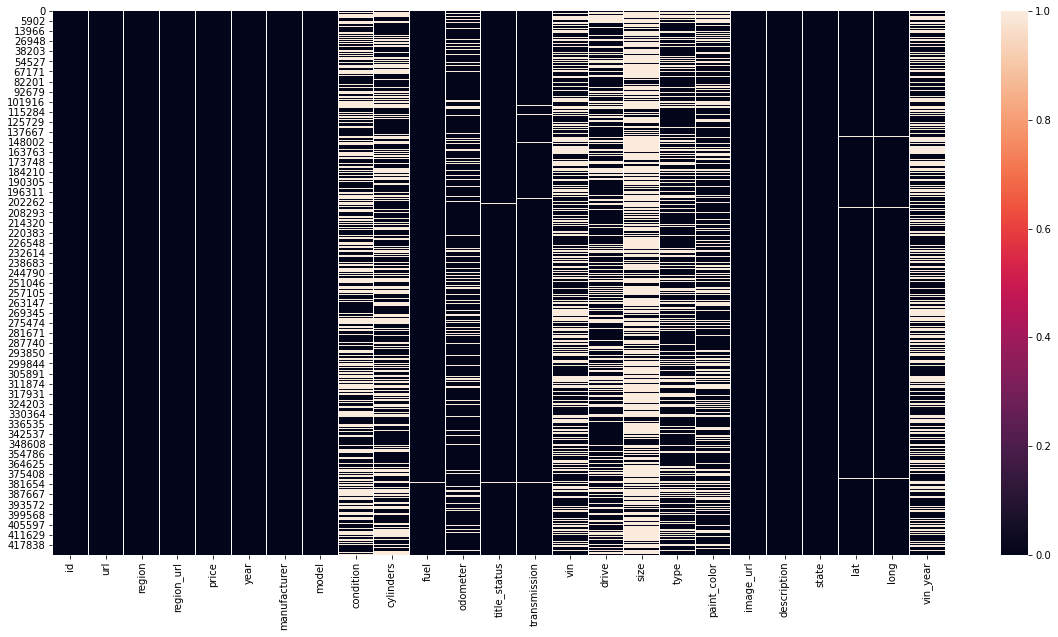

In [27]:
#set the size of the plot to make it easier to view
plt.figure(figsize=(20,10))

#use seaborn's heatmap to visualize where the null values are
sns.heatmap(dropped_df.isnull())

In [28]:
dropped_df.shape

(266524, 25)

### <span id="KNN"> KNN Impute missing values </span>

1 of 3. Explored 3 ways to impute missing values.

NOTE: below is another, more specific way to impute missing values. Due to the size of the dataset and how memory intensive KNN is, the code below is commented out, but left as a guide for future projects. See next section Fill Missing Values via Pandas Fillna

In [29]:
#loop through dataframe and map through each categorical type column replacing strings with numerical values.
def map_cat(df):
    for c in df.columns:
        if df[c].dtype == np.object:
            map_condition = {v: 1+i for i,v in enumerate(df[c].unique())}
            new_column = str(c)+'_map'
            df[c] = df[c].map(map_condition)
    return df

In [30]:
#copy the dataframe to be mapped to numerical values
to_map = dropped_df.copy()

#assign the result of map_cat
to_fill = map_cat(to_map)

In [31]:
to_fill.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,vin_year
0,7184791621,1,1,1,6995,2000.0,1,1,1,1,...,1,1,1,1,1,1,1,46.8433,-92.2550,2000.0
1,7184773187,2,1,1,8750,2013.0,2,2,1,2,...,2,1,1,2,2,2,1,46.9074,-92.4638,NaN
2,7193375964,3,2,2,10900,2013.0,3,3,2,2,...,2,1,1,3,3,3,2,41.1770,-73.1336,NaN
3,7195108810,4,3,3,12500,2003.0,4,4,2,2,...,1,2,2,2,4,4,3,35.1868,-106.6650,NaN
4,7184712241,5,1,1,16995,2007.0,1,5,2,1,...,1,3,3,4,5,5,1,45.6836,-92.9648,2007.0


In [32]:
imputer = KNNImputer(n_neighbors=3)

In [33]:
#sample the df as the data is too large for reasonable output times. 
fit_df = to_fill.sample(n=3000, random_state=1)

imputer.fit(fit_df)

KNNImputer(n_neighbors=3)

In [34]:
knn_fill = pd.DataFrame(data=imputer.transform(to_fill), columns=to_fill.columns)

In [35]:
knn_fill.isnull().sum()

id              0
url             0
region          0
region_url      0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
vin             0
drive           0
size            0
type            0
paint_color     0
image_url       0
description     0
state           0
lat             0
long            0
vin_year        0
dtype: int64

### <span id="Fillna">Custom Fill Missing Values</span>

2 of 3. Explored 3 ways to impute missing values.

In [69]:
# filled_df = dropped_df.fillna(dropped_df.mean())

to_fill = dropped_df.copy()

In [70]:
# #set the size of the plot to make it easier to view
# plt.figure(figsize=(20,10))

# #use seaborn's heatmap to visualize where the null values are
# sns.heatmap(filled_df.isnull())

to_fill['id'].mean()

7189037499.4385605

In [71]:
#fillna with mean for numerical types and median for categorical types
def fillAll(df):
    for c in df.columns:
        if df[c].dtype == np.int64 or df[c].dtype == np.float64:
            #assert df[c].dtype == np.int64 or df[c].dtype == np.float64, 'not an number'
            df[c] = df[c].fillna(df[c].mean())
        elif df[c].dtype == np.object:
            #assert df[c].dtype == np.object, 'not a object'
            df[c] = df[c].fillna(df[c].mode()[0])
        else:
            return 'error in custom function'
    return df

In [72]:
custom_fill = fillAll(to_fill)

In [73]:
custom_fill.isnull().sum()

id              0
url             0
region          0
region_url      0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
vin             0
drive           0
size            0
type            0
paint_color     0
image_url       0
description     0
state           0
lat             0
long            0
vin_year        0
dtype: int64

### <span id="Simple"> Simple Imputer</span>

3 of 3. Explored 3 ways to impute missing values.

In [41]:
#copy dataframe 
to_fill = dropped_df.copy()

In [42]:
#initialize simpleimputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [43]:
#sample the df as the data is too large for reasonable output times. 
fit_df = dropped_df.sample(n=3000, random_state=1)

#fit simple imputer on sample size
imp_mean.fit(fit_df)

SimpleImputer(strategy='most_frequent')

In [44]:
#impute values and convert the nparray into a pandas dataframe
simple_fill = pd.DataFrame(data=imp_mean.transform(to_fill), columns = dropped_df.columns, index=dropped_df.index)

In [76]:
#check for null values
simple_fill.isnull().any()


id              False
url             False
region          False
region_url      False
price           False
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer        False
title_status    False
transmission    False
vin             False
drive           False
size            False
type            False
paint_color     False
image_url       False
description     False
state           False
lat             False
long            False
vin_year        False
dtype: bool

In [77]:
simple_fill.shape

(266524, 25)

Success! Now we have no missing values and can check for correlation between variables in exploratory analysis.

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Custom Fill'),
 Text(0.5, 0, 'Condition'),
 Text(0, 0.5, 'count')]

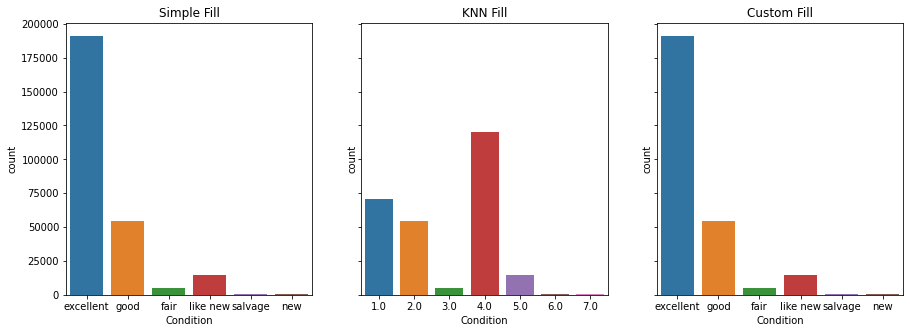

In [74]:
f, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.countplot(simple_fill['condition'], ax=axs[0]).set(title='Simple Fill', xlabel='Condition', ylabel='count')
sns.countplot(knn_fill['condition'], ax=axs[1]).set(title='KNN Fill', xlabel='Condition', ylabel='count')
sns.countplot(custom_fill['condition'], ax=axs[2]).set(title='Custom Fill', xlabel='Condition', ylabel='count')

### <span id="Conclusion"> Data Wrangling Conclusion</span>

The original data had a shape of (423857, 26). <br>
After purging the data for relevancy to our business model, the data shape is now (266524, 25)

Note: Features may be added depending on exploratory analysis

After filling in missing values 3 different ways, the count plots demonstrate that KNN Imputer has the most diverse added values. We will continue with the KNN Imputer dataframe for the next step in the project.

There is more data to be extracted from the VIN number before filling in missing values like we did, however, these methods are less streamlined than extracting the year from the VIN like we did earlier. So, for this project we will continue with the current state of our data. 

All in all, the data has been cleaned, checked for duplicates, missing values 